<a href="https://colab.research.google.com/github/Anku5hk/The_ML_Workflow/blob/master/Pytorch/Object_Detection/Train_Feature_extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Train a CNN(backbone for Faster R-CNN)

Here, we will make a CNN model to classify cars which will be the backbone for Faster R-CNN. I am using stanford cars dataset for cars and coco's val2017 set as non-cars dataset. From both ~4000 for training and ~400 for validation.
* Make Dataset
* Prepare Resnet18
* Train model
* Plot results

Download data

In [ ]:
import torch, torchvision
import os
import numpy as np
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
print(torch.cuda.get_device_name(0)) 

Tesla P100-PCIE-16GB


In [ ]:
!wget http://imagenet.stanford.edu/internal/car196/cars_train.tgz

--2020-07-05 11:21:49--  http://imagenet.stanford.edu/internal/car196/cars_train.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘cars_train.tgz’

cars_train.tgz      100%[===================>] 933.90M  19.4MB/s    in 56s     

2020-07-05 11:22:45 (16.7 MB/s) - ‘cars_train.tgz’ saved [979269282/979269282]



In [ ]:
# !tar -xzf /content/cars_train.tgz

In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip

--2020-07-05 11:22:59--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.47.76
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.47.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  32.2MB/s    in 25s     

2020-07-05 11:23:24 (31.1 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [ ]:
# !unzip /content/val2017.zip

In [ ]:
# non cars images list

ROOT_DIR_NON_CARS = '/content/val2017/' # val coco
non_cars = os.listdir(ROOT_DIR_NON_CARS)[:4500]
len(non_cars)

4500

In [ ]:
# cars images list

ROOT_DIR_CARS = '/content/cars_train/' # stanford cars
cars = os.listdir(ROOT_DIR_CARS)[:4500]
len(cars)

4500

In [ ]:
# resize all images to 224, turn to tensor, remove single channel images

cuda0 = torch.device('cuda:0')

cars_images = []
non_cars_images = []
c = 0
for i, image in enumerate(cars): 
  try:
    img = Image.open(ROOT_DIR_CARS + image)
    img = img.resize((224, 224))
    img = torch.tensor(np.array(img).reshape(3, 224, 224), device=cuda0, dtype=torch.float32)        
    cars_images.append(img)
  except Exception: 
    continue
    
for image in non_cars: 
  try:
    img = Image.open(ROOT_DIR_NON_CARS + image)
    img = img.resize((224, 224))
    img = torch.tensor(np.array(img).reshape(3, 224, 224), device=cuda0, dtype=torch.float32)
    non_cars_images.append(img)
  except Exception: 
    continue

print('Done')  

Done


In [ ]:
print(len(cars_images), len(non_cars_images)) # excluding single channel images

4492 4492


Show Data

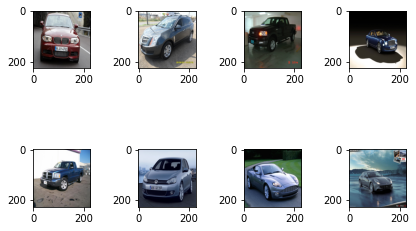

In [ ]:
# cars

samples = []


for i,image in enumerate(cars):
  img = Image.open(ROOT_DIR_CARS + image)
  img = img.resize((227, 227))
  samples.append(img)
  if i == 8:
    break

r,c = 2,4
f, axs = plt.subplots(r,c)
f.tight_layout()
a= 0

for i in range(r):
  for j in range(c):
    axs[i,j].imshow(samples[a])
    a+=1

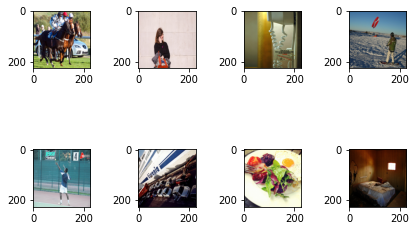

In [ ]:
# non cars

samples = []


for i,image in enumerate(non_cars):
  img = Image.open(ROOT_DIR_NON_CARS + image)
  img = img.resize((227, 227))
  samples.append(img)
  if i == 8:
    break

r,c = 2,4
f, axs = plt.subplots(r,c)
f.tight_layout()
a= 0

for i in range(r):
  for j in range(c):
    axs[i,j].imshow(samples[a])
    a+=1

Make Dataset

In [ ]:
class MakeDataset(Dataset):

  def __init__(self, images_list, transform=None, train=True):
    self.transform = transform
    self.train = train
    self.images_ids1 = images_list[0]
    self.images_ids2 = images_list[1]

    if train:
      self.X = [None]*8000
      self.X[:4000] = self.images_ids1[:4000]
      self.X[4000:] = self.images_ids2[:4000]
      self.len = 8000
      
    else:
      self.X = [None]*800
      self.X[:400] = self.images_ids1[4000:4400]
      self.X[400:] = self.images_ids2[4000:4400]   
      self.len = 800

    self.Y = torch.zeros([self.len],device=cuda0, dtype=torch.int64)
    self.Y[:int(self.len/2)] = 0
    self.Y[int(self.len/2):] = 1

  def __len__(self):
    return self.len

  def __getitem__(self, index):
    image = self.X[index]
    label = self.Y[index]
    if self.transform:
        image = self.transform(image)
        
    return image, label

In [ ]:
# compute std and mean for dataset

dataset = MakeDataset([cars_images, non_cars_images], train=True, transform=None)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=10,  
                                           shuffle=False)
mean = 0.
std = 0.
nb_samples = 0.
for data in dataloader:
    batch_samples = data[0].size(0)
    data[0] = data[0].view(batch_samples, data[0].size(1), -1)
    data[0] = data[0].float()
    mean += data[0].mean(2).sum(0)
    std += data[0].std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(mean)
print(std)

tensor([128.4757, 111.7158, 104.5615], device='cuda:0')
tensor([54.9589, 62.1771, 53.8309], device='cuda:0')


In [ ]:
# normalize using the values

transform = transforms.Compose([transforms.Normalize(mean, std)])

train_dataset = MakeDataset([cars_images, non_cars_images], train=True, transform=transform)
val_dataset = MakeDataset([cars_images, non_cars_images], train=False, transform=transform)
print('Train Dataset {} and Test Dataset {}'.format(len(train_dataset), len(val_dataset)))

Train Dataset 8000 and Test Dataset 800


In [ ]:
# prepare dataloader

BATCH_SIZE = 256

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,
                                         shuffle=False)

In [ ]:
train_dataset[6][0].size() # check image size

torch.Size([3, 224, 224])

Prepare Resnet

In [ ]:
# prepare resnet18
def make_model():
  
  model = models.resnet18(pretrained=True).cuda(0)
  model.requires_grad_(False) # set parameters to non trainable
  model.fc = torch.nn.Linear(in_features=512, out_features=2).cuda(0)
  return model

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# training

def train_model(model, EPOCHS, optimizer, scheduler, BATCH_SIZE, train_loader, val_loader):

  TRAIN_LOSS = []
  VAL_LOSS = []
  VAL_ACC = []
  cost_function = torch.nn.CrossEntropyLoss()

  TRAIN_STEP = len(train_loader)/BATCH_SIZE # to calculate loss
  VALID_STEP = len(val_loader)/BATCH_SIZE

  for epoch in range(EPOCHS):
    running_loss = 0.0

    for (x, y) in train_loader:
      model.train()
      optimizer.zero_grad()

      z = model(x)
      loss = cost_function(z, y)
      loss.backward()
      optimizer.step()
      running_loss+=loss.item()

    train_l = running_loss/TRAIN_STEP
    TRAIN_LOSS.append(train_l)
    total = 0
    correct = 0 
    print("Epoch", epoch+1)
    print("Training loss:", train_l) 
    running_loss = 0.0

    for (x,y) in val_loader:
      model.eval()
      z = model(x)
      loss = cost_function(z, y)
      scheduler.step()
      running_loss+=loss.item()
      _, yhat = torch.max(z,1)
      total += y.size(0)
      correct += (yhat == y).sum().item()

    valid_l = running_loss/VALID_STEP
    valid_a = 100 * correct / total
    print("Valid loss:", valid_l) 
    VAL_LOSS.append(valid_l)
    torch.cuda.empty_cache()
    print('VAL_Accuracy: %d %%' % valid_a)
    VAL_ACC.append(valid_a)
    
  return VAL_LOSS, TRAIN_LOSS, VAL_ACC  

In [ ]:
# train last layer only

LR = 0.01
EPOCHS = 30

model = make_model()

# model.layer4.requires_grad_(True) # also for one upper layer
model.fc.requires_grad_(True)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10)

val_loss, train_loss, _ = train_model(model, EPOCHS, optimizer, scheduler2, 
                                            BATCH_SIZE, train_loader, val_loader)


Epoch 1
Training loss: 180.1290214061737
Valid loss: 115.21898651123047
VAL_Accuracy: 82 %
Epoch 2
Training loss: 102.28628015518188
Valid loss: 93.20940399169922
VAL_Accuracy: 84 %
Epoch 3
Training loss: 98.74145102500916
Valid loss: 86.58922576904297
VAL_Accuracy: 85 %
Epoch 4
Training loss: 93.48633933067322
Valid loss: 88.50626945495605
VAL_Accuracy: 85 %
Epoch 5
Training loss: 91.89015603065491
Valid loss: 88.5482120513916
VAL_Accuracy: 85 %
Epoch 6
Training loss: 92.52359938621521
Valid loss: 88.03541374206543
VAL_Accuracy: 85 %
Epoch 7
Training loss: 91.4266927242279
Valid loss: 87.88673210144043
VAL_Accuracy: 85 %
Epoch 8
Training loss: 91.73912405967712
Valid loss: 87.38496398925781
VAL_Accuracy: 85 %
Epoch 9
Training loss: 92.71473932266235
Valid loss: 88.22612190246582
VAL_Accuracy: 85 %
Epoch 10
Training loss: 91.64459538459778
Valid loss: 88.22502326965332
VAL_Accuracy: 85 %
Epoch 11
Training loss: 91.83143544197083
Valid loss: 88.01420783996582
VAL_Accuracy: 85 %
Epoch 12

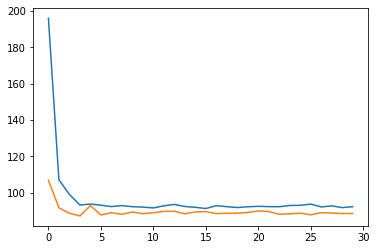

In [ ]:
# last layer

epochs = np.arange(0,EPOCHS)
plt.plot(epochs,train_loss)
plt.plot(epochs,val_loss)
plt.show()

In [ ]:
# save model

PATH = '/content/resnet_carclassifer.pth'
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

# load model weights

loaded_model = make_model()
checkpoint = torch.load(PATH)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

print('Loaded')

Loaded


In [ ]:
# fine tune layer4

LR = 0.001
EPOCHS = 50

model.layer4.requires_grad_(True) # also for one upper layer
model.fc.requires_grad_(True)

optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=7)
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20)

val_loss, train_loss, _ = train_model(model, EPOCHS, optimizer, scheduler2, 
                                            BATCH_SIZE, train_loader, val_loader)


Epoch 1
Training loss: 91.36438536643982
Valid loss: 87.13870048522949
VAL_Accuracy: 85 %
Epoch 2
Training loss: 90.21657109260559
Valid loss: 87.05753135681152
VAL_Accuracy: 85 %
Epoch 3
Training loss: 87.66287803649902
Valid loss: 86.06722450256348
VAL_Accuracy: 85 %
Epoch 4
Training loss: 86.26221776008606
Valid loss: 84.6610336303711
VAL_Accuracy: 85 %
Epoch 5
Training loss: 85.07556509971619
Valid loss: 83.96514511108398
VAL_Accuracy: 86 %
Epoch 6
Training loss: 85.33995223045349
Valid loss: 84.65800666809082
VAL_Accuracy: 86 %
Epoch 7
Training loss: 84.41132855415344
Valid loss: 84.2490234375
VAL_Accuracy: 86 %
Epoch 8
Training loss: 84.5961766242981
Valid loss: 83.28616905212402
VAL_Accuracy: 86 %
Epoch 9
Training loss: 83.82210850715637
Valid loss: 84.27031326293945
VAL_Accuracy: 86 %
Epoch 10
Training loss: 84.31944680213928
Valid loss: 84.13009262084961
VAL_Accuracy: 86 %
Epoch 11
Training loss: 83.96040987968445
Valid loss: 83.79816055297852
VAL_Accuracy: 86 %
Epoch 12
Train

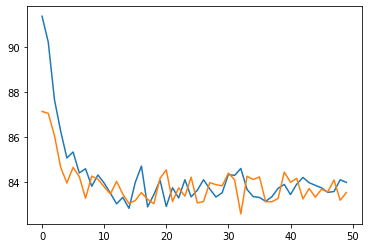

In [ ]:
# one upper layer also

epochs = np.arange(0,EPOCHS)
plt.plot(epochs,train_loss)
plt.plot(epochs,val_loss)
plt.show()

Some tests

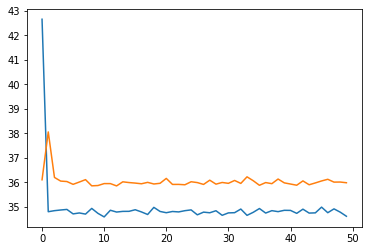

In [ ]:
# no pretrained

epochs = np.arange(0,50)
plt.plot(epochs,TRAIN_LOSS)
plt.plot(epochs,VAL_LOSS)
plt.show()

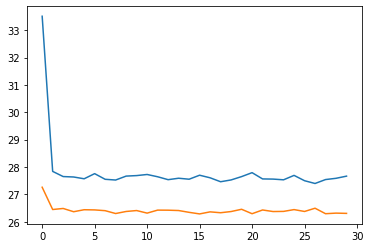

In [ ]:
# pretrained

epochs = np.arange(0,EPOCHS)
plt.plot(epochs,TRAIN_LOSS)
plt.plot(epochs,VAL_LOSS)
plt.show()

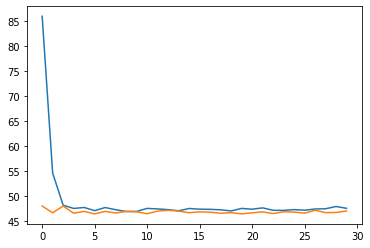

In [ ]:
# batch size 128, starting lr 0.01

epochs = np.arange(0,EPOCHS)
plt.plot(epochs,TRAIN_LOSS)
plt.plot(epochs,VAL_LOSS)
plt.show()

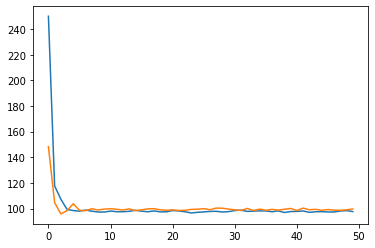

In [ ]:
# batch size 256, starting lr 0.01, step 10

epochs = np.arange(0,EPOCHS)
plt.plot(epochs,TRAIN_LOSS)
plt.plot(epochs,VAL_LOSS)
plt.show()

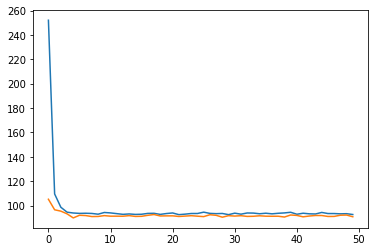

In [ ]:
# batch size 256, starting lr 0.01, step 10

epochs = np.arange(0,EPOCHS)
plt.plot(epochs,TRAIN_LOSS)
plt.plot(epochs,VAL_LOSS)
plt.show()

In [ ]:
print('Final Accuracy',VAL_ACC[len(VAL_ACC)-1])

Final Accuracy 85.25


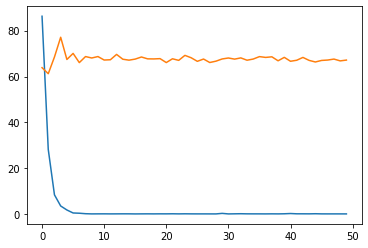

In [ ]:
# fine tuning layer4, last layer, 0.01, step 10

epochs = np.arange(0,EPOCHS)
plt.plot(epochs,TRAIN_LOSS)
plt.plot(epochs,VAL_LOSS)
plt.show()

In [ ]:
print('Final Accuracy',VAL_ACC[len(VAL_ACC)-1])

Final Accuracy 92.125


In [ ]:
PATH = '/content/drive/My Drive/train/resnet_carclassifer.pt'
torch.save(model.state_dict(), PATH)
print('Model Saved')

Now That the model is ready, we can use it inside an Object detector.